# Neural Networks for Function Extrapolation

Marco Sousa 

Department of Mathematics

Date: 4/30/2021

Objective: The goal is to use the neural network architecture to train discretized values of f(x) along [a,b] (or raw numerical data) to extrapolate values outside of [a,b]. 

Details: The essential idea is to produce f grid points f(xn),f(xn-1),...,f(xn-k) to predict f(xn+1). This is a familiar technique in numerical analysis.

Much of the architecture for this work is developed from Prof. Alfa Heryudono (UMass Darthmouth)

## Importing

In [1]:
#Importing libraries
import numpy as np 
import pandas as pd

#Machine Learning libraries
from tensorflow import keras
from tensorflow.keras import layers

#Visualization libraries
import matplotlib.pyplot as plt
#import altair as alt

#In case we only want these in our space
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## Observing x and f(x)

In [2]:
def dataFunc(x):
  """
  Input: Single variable array x
  Output: Calculated f(x) array
  """
  return np.e**(-x**2)*np.sin(15*np.pi*x)-x*np.cos(0.5*np.pi*x)

In [3]:
#The intuitive xPoints has small error when passing through 0:
xPointsBad = np.arange(-1,2.005,0.005)

#Instead, I create a grid from [-1,0)[0,2]
x1 = np.arange(-1,0,0.005)
x2 = np.arange(0,2.005,0.005)
xPointsFull = np.concatenate((x1,x2))

In [4]:
xPointsBad[500:550] == xPointsFull[500:550]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [5]:
xPointsBad[550]

1.7500000000000027

In [6]:
xPointsFull[550]

1.75

In [7]:
dataDiscretize = dataFunc(xPointsFull)

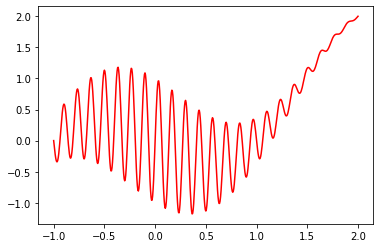

In [8]:
plt.plot(xPointsFull,dataDiscretize,'-',color='red')

## Training NN Model

Now that we've viewed our function, let's try training on [-1,1] to predict forward.

In [9]:
#Function f(x)
def dataFunc(x):
  """
  Input: Single variable array x
  Output: Calculated f(x) array
  """
  return np.e**(-x**2)*np.sin(15*np.pi*x)-x*np.cos(0.5*np.pi*x)

In [10]:
#Defining x grid points
x1 = np.arange(-1,0,0.005)
x2 = np.arange(0,1.005,0.005)
xPoints = np.concatenate((x1,x2))

In [11]:
xPoints.shape

(401,)

In [12]:
dataDiscretize = dataFunc(xPoints)

In [13]:
#Defining moving window
ww = 50

In [14]:
#This is to partition the data into vectors containing last 50 points f(xn)...
offset = 1
sublist_size = ww
result = [[xPoints[i + n] for n in range(sublist_size)] for i in range(0, len(xPoints) - sublist_size, offset)]
res = np.array(result)
res.shape

(351, 50)

In [15]:
#Input features (last 50) and output f(xn)
input = dataFunc(res)
output = dataFunc(xPoints[ww:])

In [16]:
input.shape

(351, 50)

In [17]:
output.shape

(351,)

In [18]:
#Note that keras doesn't like this structure; it preferse (50,1)
input[0].shape

(50,)

### Training a NN Model

In [19]:
#Constructing our layers
model = Sequential([
  Dense(10, activation='relu',input_dim=ww),
  Dense(10, activation='relu'),
  Dense(10, activation='relu'),
  Dense(10, activation='relu'),
  Dense(10, activation='relu'),
  Dense(10, activation='relu'),
  Dense(1),
])

In [20]:
model.compile(
  optimizer='adam',
  loss='mean_squared_error',
)

In [21]:
model.fit(
  input, # training data
  output,
  epochs=25,
  batch_size=1,
)

Epoch 1/25
351/351 [==============================] - 2s 3ms/step - loss: 0.2087
Epoch 2/25
351/351 [==============================] - 1s 2ms/step - loss: 0.0060
Epoch 3/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 4/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 5/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 6/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 7/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 8/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 9/25
351/351 [==============================] - 0s 1ms/step - loss: 8.3976e-04
Epoch 10/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 11/25
351/351 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 12/25
351/351 [==============================] - 0s 1ms/step - loss: 9.4031e-04
Epoch 13/25
351/3

In [22]:
#Make predictions along given data
pred = model.predict(input)

In [23]:
#I'm actually observing next 50 points; so am offset
h = .005
h*ww

0.25

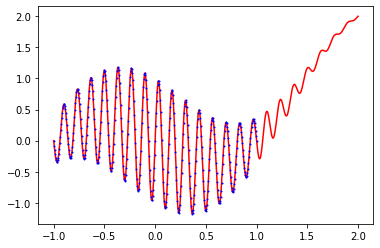

In [24]:
#Just red f(x) and blue points x
plt.plot(xPointsFull,dataFunc(xPointsFull),'-',color='red')
plt.plot(xPoints,dataFunc(xPoints),'o',markersize=1,color='blue' )

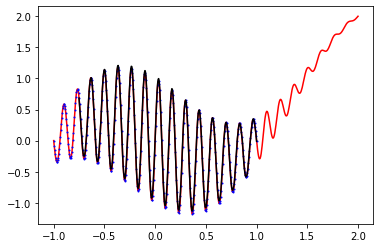

In [25]:
#Observe black line versus red line
plt.plot(xPointsFull,dataFunc(xPointsFull),'-',color='red')
plt.plot(xPoints,dataFunc(xPoints),'o',markersize=1,color='blue' )
plt.plot(xPoints[0:len(xPoints)-ww]+.005*ww,pred,color='black')

Nice; it seems to fit decently well along our training interval!

## Testing the Model

In [26]:
#Cut for initial values
xe = xPoints[-ww:]
fe = dataFunc(xe)

In [27]:
#A single prediction
model.predict(fe.reshape(-1,ww))

array([[-0.10808248]], dtype=float32)

In [28]:
#Implementing a moving window with appending
#If appending is not wanted; we could make an array and a generator to pass over that array 
#(like in convo/maxpool applications, but only in 1D)

xe2 = xe
fe2 = fe
for _ in range(0,200):
  #We add 0.005 to increment one point forward (hence fe)
  xe2 = np.append(xe2,(xe2[-1]+.005))
  
  #The last 50 points in moving window for prediction forward
  last50xe = dataFunc(xe2[-ww:])
  
  #A single prediction forward using the last 50 points f(xn...xn-k) ->f(xn+1)
  fePrediction = model.predict(last50xe.reshape(-1,ww))

  #Appending that prediction
  fe2 = np.append(fe2,fePrediction)

In [29]:
xe2.shape

(250,)

In [30]:
fe2.shape

(250,)

## Results

The following are the results for ww=50, batch=1 (Stochastic Gradient Descent)

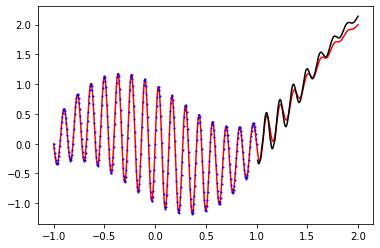

In [31]:
plt.plot(xPointsFull,dataFunc(xPointsFull),'-',color='red')
plt.plot(xPoints,dataFunc(xPoints),'o',markersize=1,color='blue' )
plt.plot(xe2[ww+1:],fe2[ww+1:],color='black')

In [32]:
testPoints = np.arange(1.005,2.005,.005)
fx = dataFunc(testPoints)

In [33]:
#mse1 = np.sum((fx - fe2[50:])**2)/(fx.shape[0])

from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(fx, fe2[50:])
mse1

0.007416467866312229

The following are the results for ww=50, batch=64

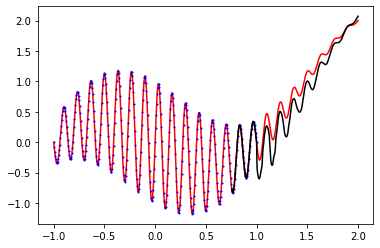

In [914]:
plt.plot(xPointsFull,dataFunc(xPointsFull),'-',color='red')
plt.plot(xPoints,dataFunc(xPoints),'o',markersize=1,color='blue' )
plt.plot(xe2,fe2,color='black')

In [915]:
mse2 = mean_squared_error(fx, fe2[50:])
mse2

0.039193676936894704

The following are the results for ww=100, batch=1

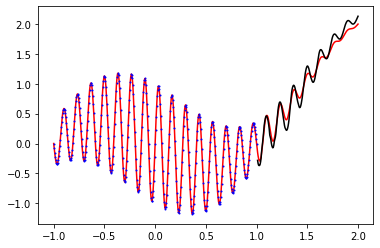

In [938]:
#This only used 50 grid points, BUT it used stochastic gradient descent (rather than batch)
plt.plot(xPointsFull,dataFunc(xPointsFull),'-',color='red')
plt.plot(xPoints,dataFunc(xPoints),'o',markersize=1,color='blue' )
plt.plot(xe2[ww+1:],fe2[ww+1:],color='black')

In [940]:
mse3 = mean_squared_error(fx, fe2[100:])
mse3

0.008805383415751116

This is a quick demonstration of my work reproducing the first application provided by Professor Heryudono. 

One observation is that more grid points, for my case, actually increased mse slightly. Well huh! That's not right. I'd have to consider this further.

Another observation is that we can instead use a generator to move the window over xe, and store in an array, rather than appending, which would reduce complexity, if needed in the prototype. 

**Thank you for reading my work and considering my application.** This was an exciting use of machine learning and numerical, and I hope to work with you over the summer!